# Übung 3 - Kraftwerkseinsatzplanung



# 3.1. Fossiler Kraftwerkspark
Ziel dieser Aufgabe ist es den kostenminimalen Kraftwerkseinsatz und die Stromversorgungskosten sowie die Gesamtemissionen zu ermittelt. Dazu wird vorerst keine Stromerzeugung mit erneuerbaren Technologien und Speicher berücksichtigt. 

## a) Gesamtkosten und -Emissionen bei kostenminimalen Kraftwerkseinsatz

In [1]:
#Einlesen der Module
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


T = 24
timesteps = np.arange(T)

#Zertifikatspreis
c_CO2 = 80 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
# Werte wurden auf die Angabe angepasst
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 30,
         'Gasturbine': 30} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden
df = pd.read_excel('Last_PV_Wind.xlsx')
load = df['Last Sommer [MW]'] # Gruppe 3

# Pyomo Modell aufstellen

model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)

# Zielfunktion, Kosten sollen minimiert werden
#dazu werden die Grenzkosten aller Kraftwerke zu jedem timestep summiert. 
model.obj = Objective(
    expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps), 
    sense= minimize)

#Nebenbedingungen bezüglich Leistung und Last 
def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
model.load_con = Constraint(timesteps, 
                            rule = load_constraint_rule)

###Schattenvariable für Punkt c)###
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value

#Berechnung der minimalen Kosten und der gesamten Emissionen
totalMinCost = model.obj()
print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR" )
totalEmissions = sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)
print("Gesamte CO2 Emissionen", totalEmissions, "tCO2" )

Model unknown

  Variables:
    x : Size=72, Index={Kohle, GuD, Gasturbine}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key                : Lower : Value : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 8) :     0 :   0.0 :  None : False : False : NonN

## b) Grafische Darstellung der Situation

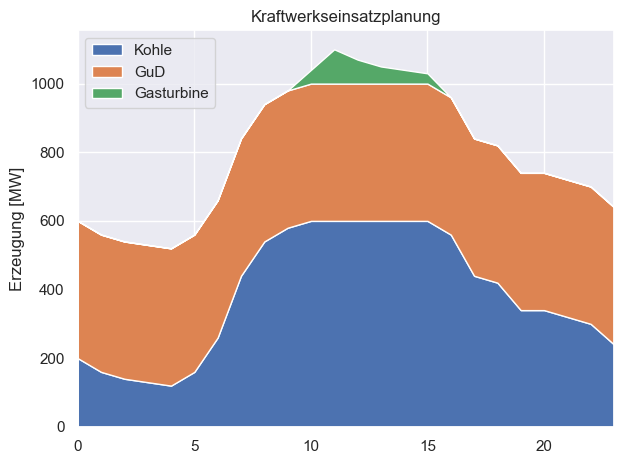

In [21]:
# plot

sns.set()

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

In der Grafik ist ersichtlich, dass zwischen 22 Uhr und 6 Uhr die Erzeugung geringer ist als während dem Tag. Dies lässt sich mit dem geringen Verbrauch während der Nacht erklären. Dieser Bedarf kann gänzlich mit der Erzeugung aus Kohle und Gas und Dampfmaschien gedeckt werden. Weiters ist in der Grafik eine vermehrte Erzeugung zwischen 10 und 16 Uhr zu entnehmen. Da dieser erhöhte Verbrauch während des Tages nicht mehr nur durch die Erzeugung von Kohle sowie Gas und Dampfmaschinen gedeckt werden kann, wird ebenfalls mit der Gasturbien Strom erzeugt.

c) In dieser Aufgabe sollen die stündlichen Werte der Schattenvariable der Beschränkung der Lastdeckung berechnet werden. Die Schattenvariable wurde bereits in Punkt a) eingeführt und hier mittels einer Schleife über die timesteps ausgegeben. 

In [25]:
print("Wert der Schattenvariable [EUR/MWh]:")
for t in timesteps:
    print("Stunde", t+1, ":", model.dual[model.load_con[t]])

Wert der Schattenvariable [EUR/MWh]:
Stunde 1 : 92.6829268292683
Stunde 2 : 92.6829268292683
Stunde 3 : 92.6829268292683
Stunde 4 : 92.6829268292683
Stunde 5 : 92.6829268292683
Stunde 6 : 92.6829268292683
Stunde 7 : 92.6829268292683
Stunde 8 : 92.6829268292683
Stunde 9 : 92.6829268292683
Stunde 10 : 92.6829268292683
Stunde 11 : 115.0
Stunde 12 : 115.0
Stunde 13 : 115.0
Stunde 14 : 115.0
Stunde 15 : 115.0
Stunde 16 : 115.0
Stunde 17 : 92.6829268292683
Stunde 18 : 92.6829268292683
Stunde 19 : 92.6829268292683
Stunde 20 : 92.6829268292683
Stunde 21 : 92.6829268292683
Stunde 22 : 92.6829268292683
Stunde 23 : 92.6829268292683
Stunde 24 : 92.6829268292683


Die Schattenvariable dient dazu, den Wert der Ressource (in unserem Fall ist das der Strompreis) abschätzen zu können. Sie gibt also an, welche Auswirkung die Lastbeschränkung auf den Strompreis hat.

d) Nun soll der stündliche Strompreis in [EUR/MWh] unter optimalen Wettbewerb berechnet werden. Das erzeugende Kraftwerk mit den höchsten kurzfristigen Grenzkosten gibt dabei immer den Strompreis an. 

In [55]:
print("Grenzkosten der Kraftwerke:")
print(MC)
print()
print("Strompreis [EUR/MWh]:")
for t in timesteps:
    maxMC=0
    for n in thermalPlant:
        if model.x[n,t].value > 0:
            if MC[n] > maxMC:
                maxMC=MC[n]
    print("Stunde", t+1, ":" ,maxMC)


Grenzkosten der Kraftwerke:
{'Kohle': 92.6829268292683, 'GuD': 79.3103448275862, 'Gasturbine': 115.0}

Strompreis [EUR/MWh]:
Stunde 1 : 92.6829268292683
Stunde 2 : 92.6829268292683
Stunde 3 : 92.6829268292683
Stunde 4 : 92.6829268292683
Stunde 5 : 92.6829268292683
Stunde 6 : 92.6829268292683
Stunde 7 : 92.6829268292683
Stunde 8 : 92.6829268292683
Stunde 9 : 92.6829268292683
Stunde 10 : 92.6829268292683
Stunde 11 : 115.0
Stunde 12 : 115.0
Stunde 13 : 115.0
Stunde 14 : 115.0
Stunde 15 : 115.0
Stunde 16 : 115.0
Stunde 17 : 92.6829268292683
Stunde 18 : 92.6829268292683
Stunde 19 : 92.6829268292683
Stunde 20 : 92.6829268292683
Stunde 21 : 92.6829268292683
Stunde 22 : 92.6829268292683
Stunde 23 : 92.6829268292683
Stunde 24 : 92.6829268292683


Es ist ersichtlich, dass von 17 bis 10 Uhr das Kohlekraftwerk das preissetzende Kraftwerk und zwischen 11 und 16 Uhr die Gasturbine das preissetzende Kraftwerk ist. 